# Fundamentos de analítica 2 
# Parcial Final

## Alejandra Ruiz
## Juan Camilo Vergara Arenas
## Universidad ICESI

## **Parcial final**

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos




## **1. Carga de paquetes**

In [3]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.Collecting bayesian-optimization
  Using cached bayesian_optimization-1.5.1-py3-none-any.whl.metadata (16 kB)
Using cached bayesian_optimization-1.5.1-py3-none-any.whl (28 kB)




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\aleja\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import statsmodels.api as sm 
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV
import itertools
import random

## **2. Carga de datos**


In [7]:
# Cargar los datos desde el archivo CSV
data = pd.read_csv("Examen.csv")

# Renombrar la primera columna a 'Fecha'
data.rename(columns={data.columns[0]: 'Fecha'}, inplace=True)

# Convertir la columna 'Fecha' en formato de fecha
# Suponiendo que los valores en 'Fecha' son días a partir del 1 de enero de 2023
data['Fecha'] = pd.to_datetime(data['Fecha'], unit='D', origin='2023-01-01')

# Establecer la columna 'Fecha' como índice
data.set_index('Fecha', inplace=True)

data.head()

,producto1,producto2
Fecha,,
2013-01-02,4000.000000,3000.000000
2013-01-03,3997.400893,3010.686220
2013-01-04,3978.605317,3022.018584
2013-01-05,3986.454125,3033.920990
2013-01-06,3979.695678,3038.402098


### **2.1. Descripción de los datos**

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2013-01-02 to 2013-05-08
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [8]:
# Separar los datos en dos DataFrames, uno para cada producto
data_producto1 = data[['producto1']]
data_producto2 = data[['producto2']]

In [4]:
# Mostrar los DataFrames separados
data_producto1.head()

,producto1
Fecha,
2013-01-02,4000.000000
2013-01-03,3997.400893
2013-01-04,3978.605317
2013-01-05,3986.454125
2013-01-06,3979.695678


In [17]:
df_describe = pd.DataFrame()
df_describe['producto1'] = data_producto1.describe()
df_describe['producto2'] = data_producto2.describe()

In [18]:
df_describe

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


In [5]:
# Mostrar los DataFrames separados
data_producto2.head()

,producto2
Fecha,
2013-01-02,3000.000000
2013-01-03,3010.686220
2013-01-04,3022.018584
2013-01-05,3033.920990
2013-01-06,3038.402098


### **2.2. Visualizaciones Generales**

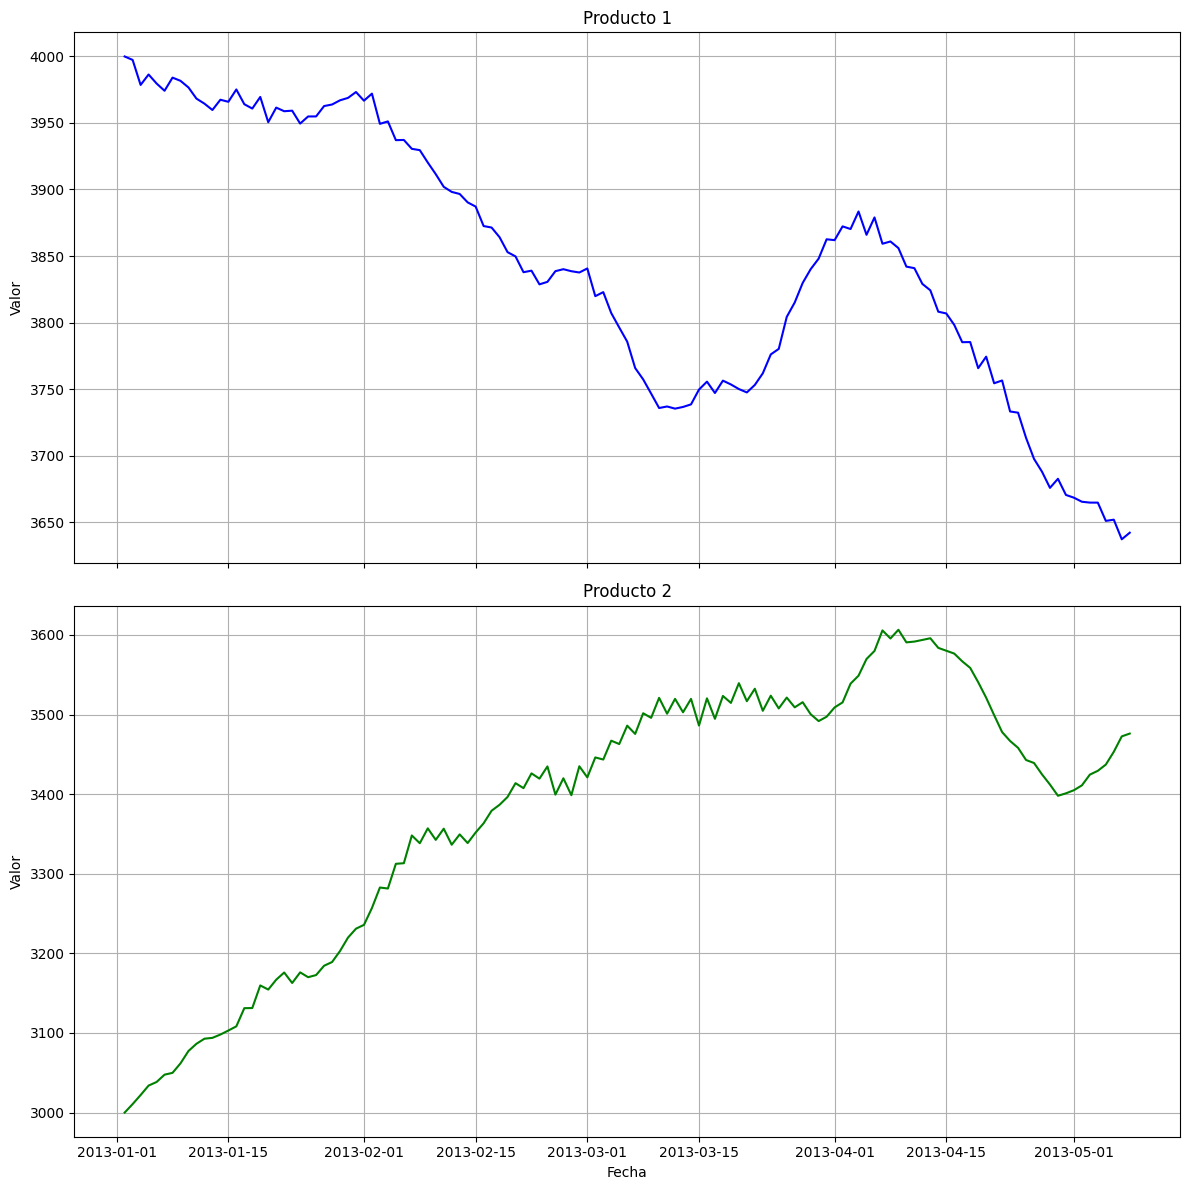

In [6]:
# Crear una figura con dos subplots verticales
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Graficar producto1 en el primer subplot
axs[0].plot(data_producto1.index, data_producto1['producto1'], color='blue')
axs[0].set_title('Producto 1')
axs[0].set_ylabel('Valor')
axs[0].grid()

# Graficar producto2 en el segundo subplot
axs[1].plot(data_producto2.index, data_producto2['producto2'], color='green')
axs[1].set_title('Producto 2')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valor')
axs[1].grid()

# Ajustar el diseño y mostrar las gráficas
fig.tight_layout()
plt.show()

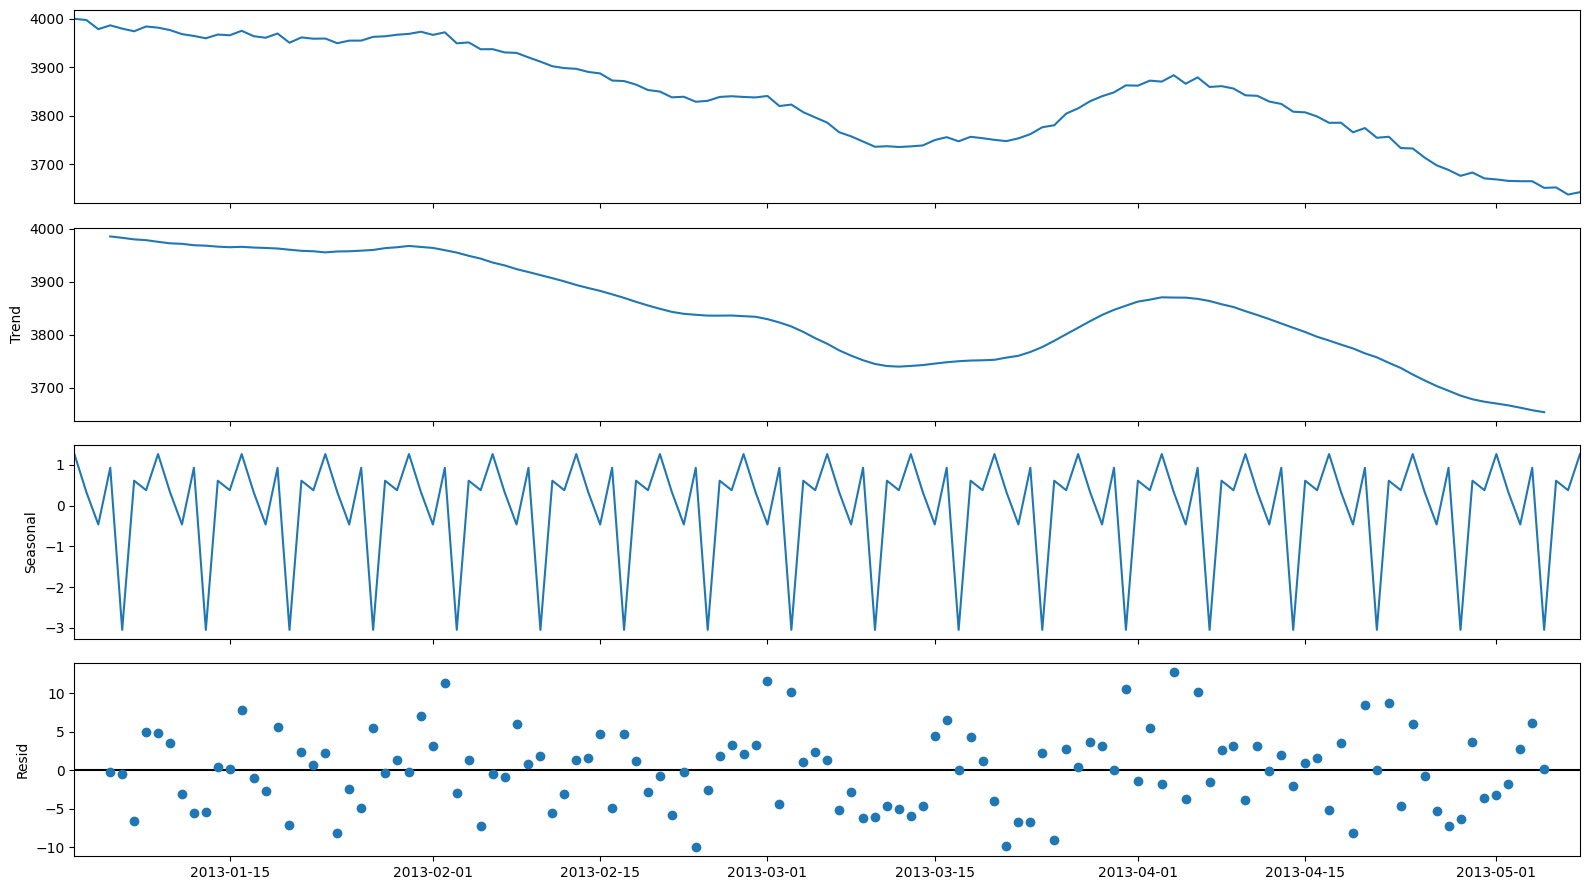

In [7]:
td_componentes1 = seasonal_decompose(data_producto1,model="additive")
fig = td_componentes1.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

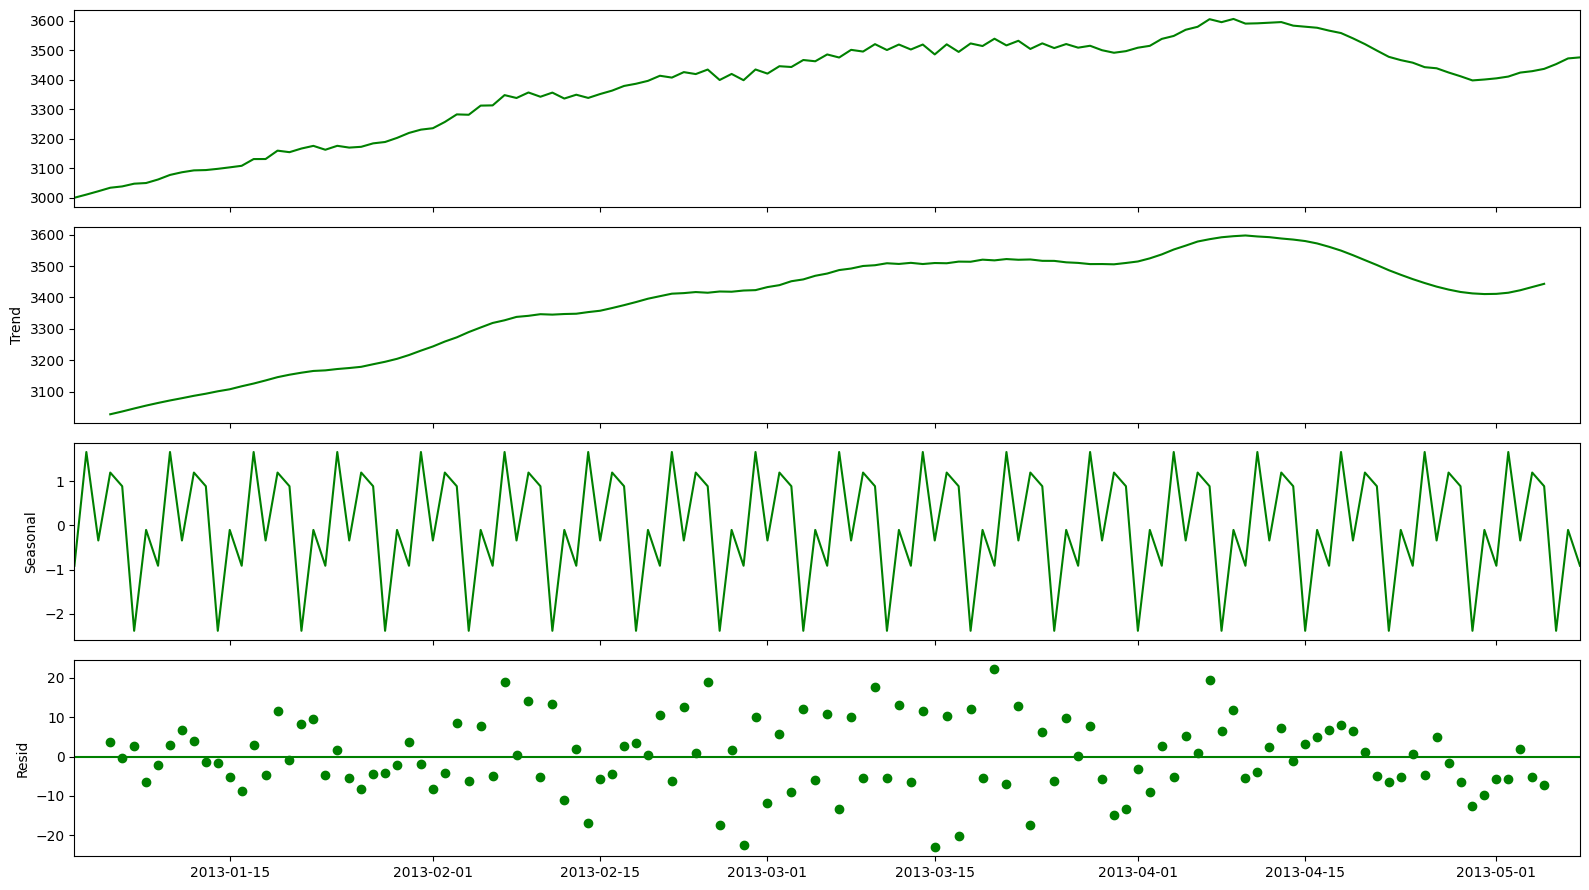

In [13]:
td_componentes2 = seasonal_decompose(data_producto2,model="additive")
fig = td_componentes2.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color("green")
plt.show()

## **3. MODELAMIENTO**

## **3.1. Protocolo de Evaluación - Ventana Móvil**

In [118]:
namecolumn = 'producto1'

In [117]:
def protocolo(df,horizonte, funcion_modelo, order=None, params=None, modelo=1):
    global namecolumn
    i = 0
    pred_rmse = {}
    
    for j in range (horizonte, 0, -1):
        train_data = df[i:len(df)-j]
        test_data = df.iloc[[len(df)-j]] 
            
        if modelo == 1:
            real, pred, rmse = funcion_modelo(order,train_data,test_data) 
        if modelo == 2:
            real, pred, rmse = funcion_modelo(params['error'],
                                                params['trend'],
                                                params['seasonal'],
                                                params['alpha'],
                                                params['beta'],
                                                params['gamma'],train_data,test_data) 
        if modelo == 3:
            real, pred, rmse = funcion_modelo(train_data,test_data,10,1,namecolumn)            
        
        pred_rmse[i] = {'real': real,
                        'pred': pred, 
                        'rmse': rmse} 
        
        #print(f"i:{i},j:{j}, pred_rmse: {pred_rmse}")
        i+=1  
          
    
    rmse_values = [value['rmse'] for value in pred_rmse.values()]

    # Calcular el promedio
    average_rmse = sum(rmse_values) / len(rmse_values)
        
    return  pred_rmse, average_rmse      
            

## **3.2. Modelo de Suavización Exponencial Holt Winters**

In [ ]:
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 0.9, None],
    'beta': [0.01, 0.1, 0.5, 0.9, None],
    'gamma': [0.01, 0.1, 0.5, 0.9, None],
    'error': ['add', 'mul'],
    'seasonal': ['add', 'mul', None],
    'trend': ['add', 'mul', None]
}

# Crear todas las combinaciones posibles de los parámetros
param_combinations = list(itertools.product(param_grid['alpha'], param_grid['beta'], param_grid['gamma'],
                                            param_grid['error'], param_grid['seasonal'], param_grid['trend']))


print(f"Total Combinaciones: {len(param_combinations)}")


Total Combinaciones: 2250


### **3.2.1 Optimización Bayesiana**

In [132]:
predicciones = []
iteraciones = 10

In [122]:
def train_and_evaluate_RMSE_bayes(error,trend,seasonal,alpha,beta,gamma):
  global iteraciones
  """Function we want to maximize (Black box)

  It first trains a model with the training set using the received hyper
  parameterts, and then evaluatesand returns the Min RMSE over the test set.
  """
  global df
  
  #train_data = data_producto1[:len(data_producto1)-10]
  #test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
  
  alpha = round(alpha,2)
  beta  = round(beta,2)
  gamma = round(gamma,2)

  error1 = ["add","mul"]
  trend1 = ["add","mul",None]
  seasonal1 = ["add","mul",None]
  
  total_rmse = 0
  
  i = 0
  for j in range (10, 0, -1):
      train_data = df[i:len(df)-j]
      test_data = df.iloc[[len(df)-j]] 
      model = ETSModel(endog=train_data[train_data.columns[0]],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])
      i+=1

      params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

      if trend1[round(trend)] == None:
        params.pop('smoothing_trend')
      if seasonal1[round(seasonal)] == None:
        params.pop('smoothing_seasonal')

      model_result = model.fit_constrained(params)

      point_forecast=model_result.forecast(1)
      rmse = np.sqrt(mean_squared_error(test_data,point_forecast ))
      
      total_rmse += rmse
          
  # Promedio de RMSE para este conjunto de parámetros
  average_rmse = total_rmse / iteraciones

  print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
        format(average_rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

  return -average_rmse

In [124]:
pbounds = {'error':  (0,1),
           'trend':(0,2) , 
           'seasonal': (0,2), 
           'alpha':(0.01,0.99) , 
           "beta" :(0.01,0.99),
           "gamma" :(0.01,0.99)}

In [13]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [14]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
 target es: 7.320287164499132,Eror test: add,Trend test: add,Seasonal test: add,Alpha model: 0.42,Beta model: 0.72, Gamma model: 0.31
| 1         | -7.32     | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
 target es: 15.717313090188918,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.19,Beta model: 0.35, Gamma model: 0.54
| 2         | -15.72    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
 target es: 116866537.36935823,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.21,Beta model: 0.87, Gamma model: 0.67
| 3         | -1.169e+0 | 0.2104    | 0.8706    | 0.02739   | 0.6671    | 0.8346    | 1.117     |
 target es: 7.967086540502487,Eror test: add,Trend test: add,Seasonal test: None,Alpha model: 0.94,Beta mo

In [15]:
optimizer.max

{'target': -4.410040599858166,
 'params': {'alpha': 0.6971637705592186,
  'beta': 0.01,
  'error': 0.0,
  'gamma': 0.01,
  'seasonal': 1.113319908104254,
  'trend': 0.8115542619293555}}

In [121]:
def transformar_params(params):
    #params = optimizer.max['params']
    error_options = ["add", "mul"]
    trend_options = ["add", "mul", None]
    seasonal_options = ["add", "mul", None]

    # Redondear y mapear los valores del diccionario a los arreglos correspondientes
    error_index = round(params['error'])  # Redondea al entero más cercano
    trend_index = round(params['trend'])
    seasonal_index = round(params['seasonal'])

    # Obtener las opciones correspondientes
    error_value = error_options[error_index]
    trend_value = trend_options[trend_index]
    seasonal_value = seasonal_options[seasonal_index]

    # Actualizar el diccionario
    params['error'] = error_value
    params['trend'] = trend_value
    params['seasonal'] = seasonal_value

    return params

In [131]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma,train_data,test_data):
    global predicciones
    model = ETSModel(endog=train_data[train_data.columns[0]],error=error,trend=trend,seasonal=seasonal)

    model_result = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

    point_forecast=model_result.forecast(1)
    predicciones.append(point_forecast)
    rmse = np.sqrt(mean_squared_error(test_data,point_forecast ))

    return test_data.iloc[0].values[0], point_forecast.values[0], rmse

In [44]:
params = transformar_params(optimizer.max['params'])
estimaciones_hot, promedio_hot = protocolo(data_producto1, 10, train_and_evaluate_RMSE,None,params,2)

In [53]:
test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
rmse_general = np.sqrt(mean_squared_error(test_data,predicciones ))

In [54]:
print(f"promedio rmse: {promedio_hot}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 5.804160840739769, rmse calculado con el total del test:7.832196408737552


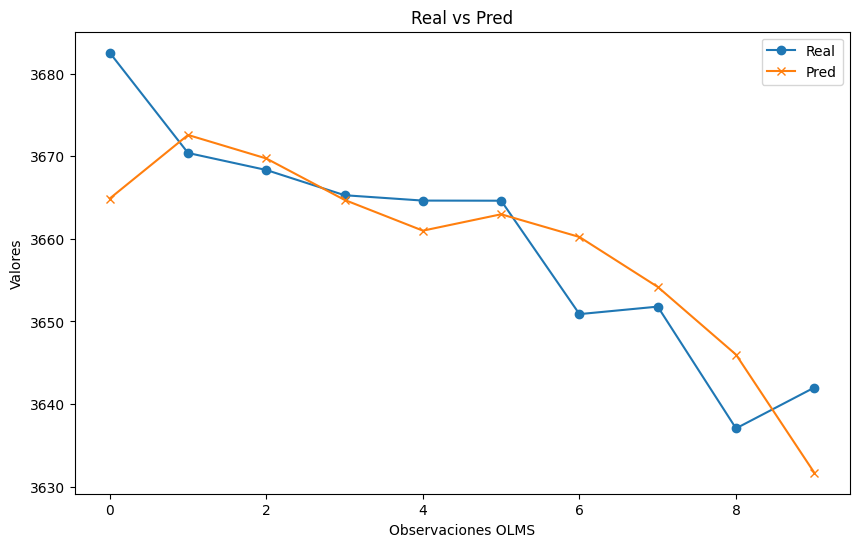

In [35]:
# Extraer los valores 'real' y 'pred' del diccionario
real_values = [value['real'] for value in estimaciones_hot.values()]
pred_values = [value['pred'] for value in estimaciones_hot.values()]

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(real_values, label='Real', marker='o')
plt.plot(pred_values, label='Pred', marker='x')

# Etiquetas y título
plt.xlabel('Observaciones OLMS')
plt.ylabel('Valores')
plt.title('Real vs Pred')
plt.legend()

# Mostrar la gráfica
plt.show()

In [36]:
estimaciones_hot

{0: {'real': 3682.52625647666,
  'pred': 3664.8764473930655,
  'rmse': 17.64980908359439},
 1: {'real': 3670.39000124754,
  'pred': 3672.569447053138,
  'rmse': 2.1794458055978794},
 2: {'real': 3668.32842509729,
  'pred': 3669.7238038707746,
  'rmse': 1.395378773484481},
 3: {'real': 3665.27459954275,
  'pred': 3664.7058203858323,
  'rmse': 0.5687791569175715},
 4: {'real': 3664.6254716928,
  'pred': 3660.9850152273375,
  'rmse': 3.6404564654626483},
 5: {'real': 3664.61077112571,
  'pred': 3662.9692882056015,
  'rmse': 1.6414829201085013},
 6: {'real': 3650.88183932508,
  'pred': 3660.2192032007392,
  'rmse': 9.337363875659321},
 7: {'real': 3651.7884696404,
  'pred': 3654.1762334100663,
  'rmse': 2.387763769666435},
 8: {'real': 3637.04763941276,
  'pred': 3645.978643686256,
  'rmse': 8.931004273496},
 9: {'real': 3641.99087267193,
  'pred': 3631.6807483885195,
  'rmse': 10.31012428341046}}

## **3.3. Modelo Tendencia con Estacionalidad**

In [86]:
def modelo_ols_estacionalidad(order,train_data,test_data):
    global predicciones
    month_dummies = pd.get_dummies(train_data.index.month, drop_first=True).set_index(train_data.index)
    y = train_data
    x = np.linspace(1, len(train_data), len(train_data))
    X_poly = np.vander(x, N=order+1, increasing=True)
    
    X_design = sm.add_constant(np.column_stack((X_poly, month_dummies)))
    
    model = sm.OLS(y, X_design)
    model_fit = model.fit()
    
    y_test = test_data
    x_test = np.linspace(len(train_data) + 1, len(train_data) + len(test_data), len(test_data))
    X_poly_test = np.vander(x_test, N=order+1, increasing=True)
    month_dummies_test = pd.get_dummies(test_data.index.month, drop_first=True).reindex(columns=month_dummies.columns, fill_value=0)
    X_test = sm.add_constant(np.column_stack((X_poly_test, month_dummies_test)))
    y_pred_test = model_fit.predict(X_test)
    predicciones.append(y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    return y_test.iloc[0].values[0], y_pred_test[0], rmse_test

In [35]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

def modelo_ols_estacionalidad(order, train_data, test_data):
    global predicciones
    
    month_dummies_train = pd.get_dummies(train_data.index.month, drop_first=True)
    month_dummies_test = pd.get_dummies(test_data.index.month, drop_first=True).reindex(columns=month_dummies_train.columns, fill_value=0)
    
    x_train = np.arange(len(train_data)).reshape(-1, 1)
    x_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
    
    poly = PolynomialFeatures(degree=order)
    X_poly_train = poly.fit_transform(x_train)
    X_poly_test = poly.transform(x_test)
    
    X_train = np.hstack((X_poly_train, month_dummies_train))
    X_test = np.hstack((X_poly_test, month_dummies_test))
    
    # Modelo de Ridge para regularización
    model = Ridge(alpha=1.0)  # Puedes ajustar el parámetro alpha para probar diferentes niveles de regularización
    model.fit(X_train, train_data)
    
    y_pred_test = model.predict(X_test)
    predicciones.append(y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(test_data, y_pred_test))
    
    return test_data.iloc[0], y_pred_test[0], rmse_test

### **3.3.1 Orden 1**

In [58]:
predicciones = []
estimaciones_ols, promedio_ols = protocolo(data_producto1, 10, modelo_ols_estacionalidad,1,1)
test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
predicciones_array = np.array([item[0, 0] for item in predicciones])
test_data_array = np.array(test_data)
rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))

print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 15.939327211413865, rmse calculado con el total del test: 17.337305225566375


In [52]:
estimaciones_ols

{0: {'real': producto1    3682.526256
  Name: 2013-04-29 00:00:00, dtype: float64,
  'pred': array([3707.95773297]),
  'rmse': 25.431476497642507},
 1: {'real': producto1    3670.390001
  Name: 2013-04-30 00:00:00, dtype: float64,
  'pred': array([3698.0151116]),
  'rmse': 27.62511035012176},
 2: {'real': producto1    3668.328425
  Name: 2013-05-01 00:00:00, dtype: float64,
  'pred': array([3687.16884787]),
  'rmse': 18.84042277443723},
 3: {'real': producto1    3665.2746
  Name: 2013-05-02 00:00:00, dtype: float64,
  'pred': array([3678.928399]),
  'rmse': 13.65379945842551},
 4: {'real': producto1    3664.625472
  Name: 2013-05-03 00:00:00, dtype: float64,
  'pred': array([3674.29182885]),
  'rmse': 9.666357159540894},
 5: {'real': producto1    3664.610771
  Name: 2013-05-04 00:00:00, dtype: float64,
  'pred': array([3670.20077779]),
  'rmse': 5.590006662175256},
 6: {'real': producto1    3650.881839
  Name: 2013-05-05 00:00:00, dtype: float64,
  'pred': array([3666.29195011]),
  'rm

In [45]:
def graficar_predicciones(estimaciones_ols): # Extraer los valores 'real' y 'pred' del diccionario
    real_values = [value['real'] for value in estimaciones_ols.values()]
    pred_values = [value['pred'] for value in estimaciones_ols.values()]

    # Crear la gráfica
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, label='Real', marker='o')
    plt.plot(pred_values, label='Pred', marker='x')

    # Etiquetas y título
    plt.xlabel('Observaciones OLMS')
    plt.ylabel('Valores')
    plt.title('Real vs Pred')
    plt.legend()

    # Mostrar la gráfica
    plt.show()

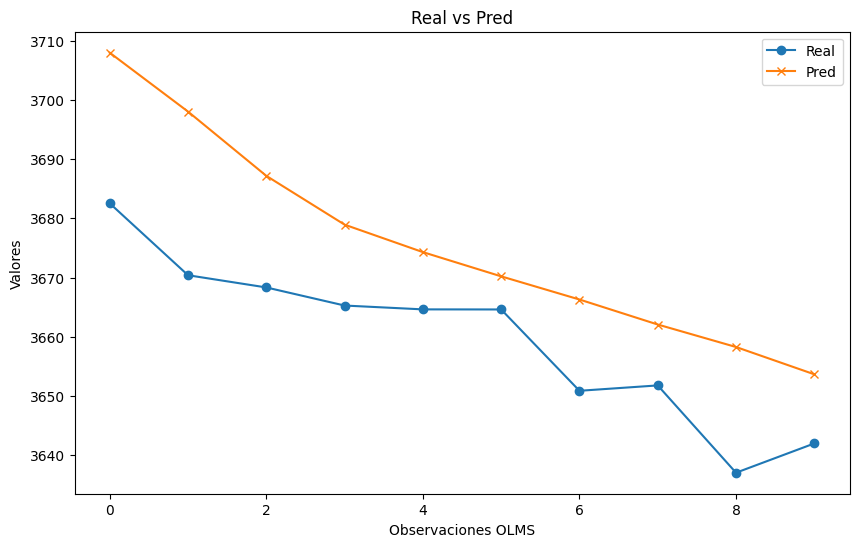

In [46]:
graficar_predicciones(estimaciones_ols)

### **3.3.2 Orden 2**

In [53]:
predicciones = []
estimaciones_ols, promedio_ols = protocolo(data_producto1, 10, modelo_ols_estacionalidad,2,1)
test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
predicciones_array = np.array([item[0, 0] for item in predicciones])
test_data_array = np.array(test_data)
rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))
print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 14.776846134018342, rmse calculado con el total del test: 15.916087671256996


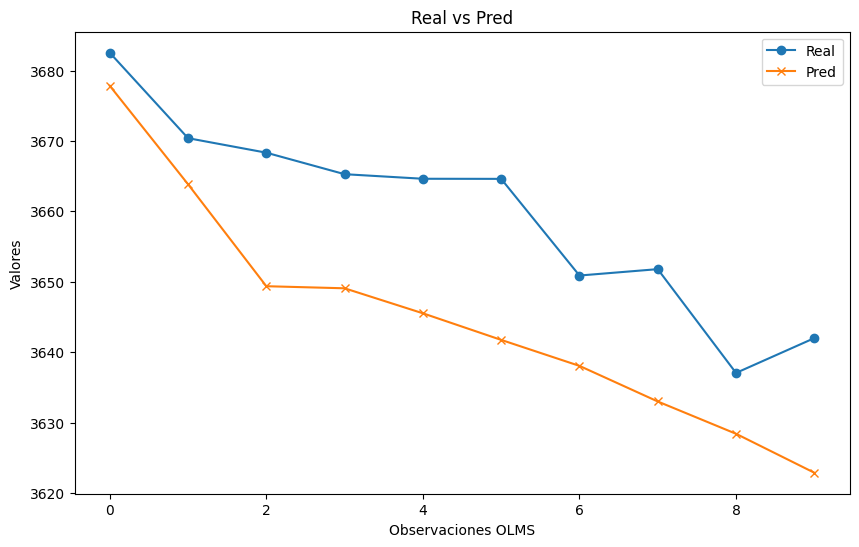

In [54]:
graficar_predicciones(estimaciones_ols)

### **3.3.3 Orden 3**

In [59]:
predicciones = []
estimaciones_ols, promedio_ols = protocolo(data_producto1, 10, modelo_ols_estacionalidad,3,1)
test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
predicciones_array = np.array([item[0, 0] for item in predicciones])
test_data_array = np.array(test_data)
rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))
print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 37.873695875041676, rmse calculado con el total del test: 39.76753595545427


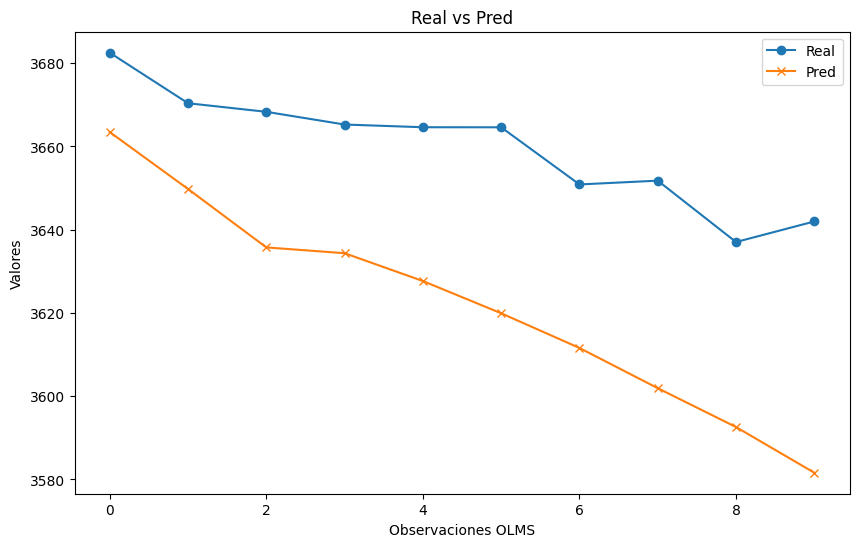

In [57]:
graficar_predicciones(estimaciones_ols)

### **3.3.4 Otros Valores de Orden**

In [98]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]
for i in range(4,9):
    predicciones = []
    estimaciones_ols, promedio_ols = protocolo(data_producto1, 10, modelo_ols_estacionalidad,i,1)
    predicciones_array = np.array([item[0, 0] for item in predicciones])
    test_data_array = np.array(test_data)
    rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))
    print(f"ORDEN {i}- promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.51768e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.51768e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.51768e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppD

ORDEN 4- promedio rmse: 109.37247022364704, rmse calculado con el total del test: 113.48020240994069
ORDEN 5- promedio rmse: 102.08301471389882, rmse calculado con el total del test: 102.56719652265501


C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.92129e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.92129e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.92129e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppD

ORDEN 6- promedio rmse: 29.79393560627691, rmse calculado con el total del test: 36.05948672352946
ORDEN 7- promedio rmse: 35.16712203671746, rmse calculado con el total del test: 40.54822232156367
ORDEN 8- promedio rmse: 30.12841264099966, rmse calculado con el total del test: 33.031438760690826


C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.58932e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.58932e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.58932e-34): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\aleja\AppD

## **3.3. Promedio Móvil**

In [116]:
def fore_ma(train_data,test_data,w,h,namecolumn):
  data=train_data.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(days=1)
    data.loc[value]= data[-w:].mean()
  
  predicciones.append(data[-h:][namecolumn].values)
  rmse_test = np.sqrt(mean_squared_error(test_data, data[-h:]))  
  
  return test_data.iloc[0], data[-h:].iloc[0], rmse_test

In [94]:
predicciones = []
estimaciones_mean, promedio_mean = protocolo(data_producto1, 10, fore_ma, None, None, 3)
rmse_general = np.sqrt(mean_squared_error(test_data,predicciones ))
print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 30.12841264099966, rmse calculado con el total del test: 34.165951556449826


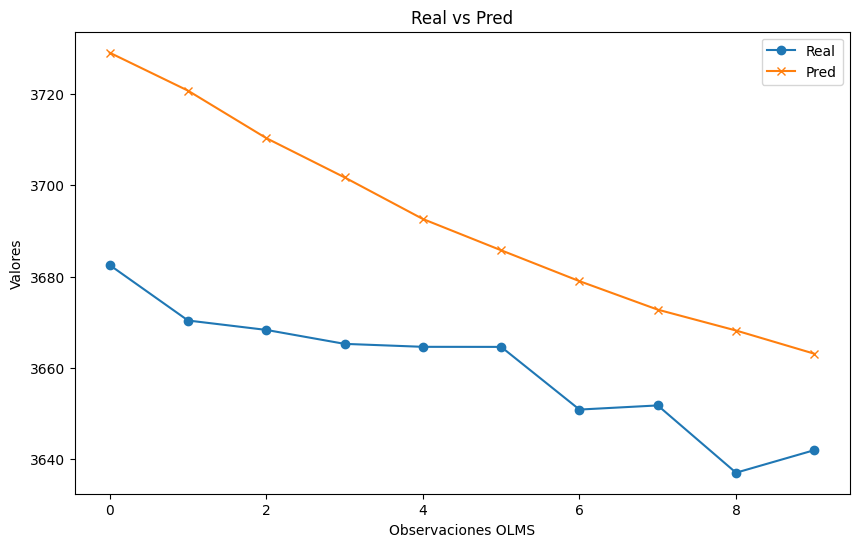

In [95]:
graficar_predicciones(estimaciones_mean)

## **3.4. ARIMA**

In [62]:
from statsmodels.tsa.arima.model import ARIMA

def train_and_evaluate_arima(order, train_data, test_data):
    """
    Entrena y evalúa un modelo ARIMA.
    
    :param order: Tuple (p, d, q) para el modelo ARIMA
    :param train_data: Datos de entrenamiento (debe ser una Serie de pandas o un array de numpy)
    :param test_data: Datos de prueba (debe ser una Serie de pandas o un array de numpy)
    :return: real, pred, rmse
    """
    # Asegúrate de que train_data y test_data son arrays numpy
    train_data = np.array(train_data)
    test_data = np.array(test_data)

    # Ajusta el modelo ARIMA
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()

    # Realiza predicciones
    predictions = model_fit.forecast(steps=len(test_data))

    # Calcula RMSE
    rmse = np.sqrt(mean_squared_error(test_data, predictions))
    
    return test_data, predictions, rmse


In [63]:
# Función para evaluar múltiples modelos ARIMA
def comparar_modelos_arima(df, horizonte, lista_ordenes):
    resultados = {}
    
    for order in lista_ordenes:
        print(f"Evaluando modelo ARIMA con orden: {order}")
        pred_rmse, average_rmse = protocolo(df, horizonte, funcion_modelo=train_and_evaluate_arima, order=order)
        resultados[order] = {
            'average_rmse': average_rmse
        }
    
    return resultados

In [64]:
# Lista de órdenes ARIMA a evaluar
lista_ordenes = [(1, 1, 1), (2, 1, 1), (1, 2, 1), (1, 1, 2), (2, 2, 2), (2, 1, 2), (3, 1, 1), (1, 1, 3)]

# Ejecutar la comparación de modelos
resultados = comparar_modelos_arima(data_producto1, horizonte=10, lista_ordenes=lista_ordenes)

# Encontrar el mejor modelo (con el menor promedio de RMSE)
mejor_modelo = min(resultados, key=lambda k: resultados[k]['average_rmse'])
print(f"\nEl mejor modelo ARIMA es el con orden {mejor_modelo} con un promedio de RMSE de {resultados[mejor_modelo]['average_rmse']}")

# Mostrar resultados promedio de RMSE por modelo
print("\nPromedio de RMSE por modelo:")
for order, result in resultados.items():
    print(f"Modelo ARIMA {order}: Promedio de RMSE = {result['average_rmse']}")

Evaluando modelo ARIMA con orden: (1, 1, 1)
Evaluando modelo ARIMA con orden: (2, 1, 1)
Evaluando modelo ARIMA con orden: (1, 2, 1)
Evaluando modelo ARIMA con orden: (1, 1, 2)
Evaluando modelo ARIMA con orden: (2, 2, 2)
Evaluando modelo ARIMA con orden: (2, 1, 2)
Evaluando modelo ARIMA con orden: (3, 1, 1)
Evaluando modelo ARIMA con orden: (1, 1, 3)

El mejor modelo ARIMA es el con orden (2, 1, 1) con un promedio de RMSE de 5.387051411074117

Promedio de RMSE por modelo:
Modelo ARIMA (1, 1, 1): Promedio de RMSE = 7.3099995266907625
Modelo ARIMA (2, 1, 1): Promedio de RMSE = 5.387051411074117
Modelo ARIMA (1, 2, 1): Promedio de RMSE = 5.90912759857697
Modelo ARIMA (1, 1, 2): Promedio de RMSE = 8.003127612060643
Modelo ARIMA (2, 2, 2): Promedio de RMSE = 6.09275939464319
Modelo ARIMA (2, 1, 2): Promedio de RMSE = 6.09677515726321
Modelo ARIMA (3, 1, 1): Promedio de RMSE = 5.414134222902203
Modelo ARIMA (1, 1, 3): Promedio de RMSE = 7.0793690611002145


In [65]:
# Definir la función para el pronóstico
def pronosticar_con_mejor_modelo(df, best_order, horizonte):
    # Ajustar el modelo ARIMA con todo el conjunto de datos
    modelo_final = ARIMA(df, order=best_order)
    modelo_ajustado = modelo_final.fit()

    # Realizar el pronóstico para el horizonte deseado
    predicciones = modelo_ajustado.get_forecast(steps=horizonte)
    predicciones_mean = predicciones.predicted_mean
    predicciones_conf_int = predicciones.conf_int()
    
    return predicciones_mean, predicciones_conf_int

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


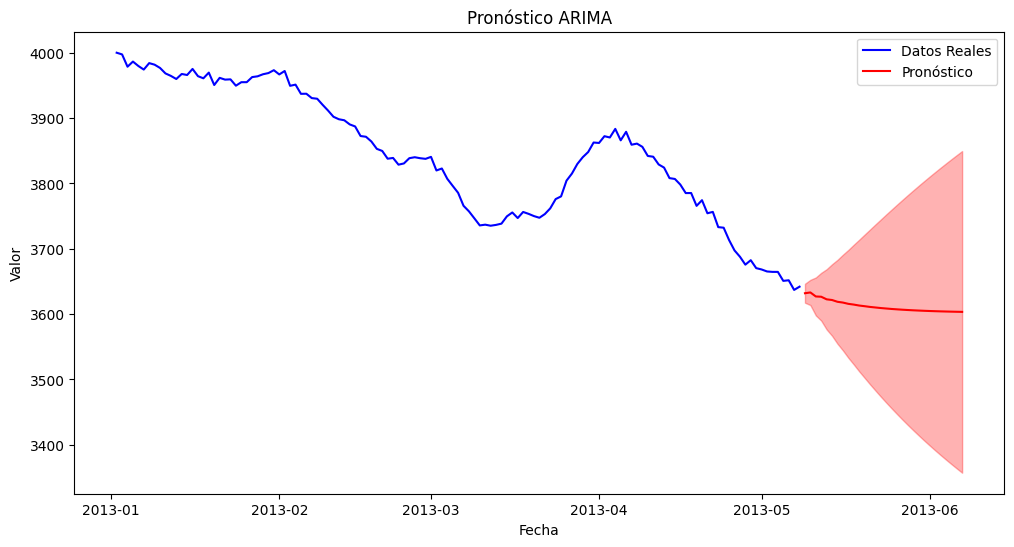

In [66]:
# Definir el horizonte de pronóstico (1 mes, ajustar según frecuencia de datos)
horizonte = 30  # Asumiendo datos diarios, ajusta si es necesario

# Pronosticar con el mejor modelo
predicciones_mean, predicciones_conf_int = pronosticar_con_mejor_modelo(data_producto1, mejor_modelo, horizonte)

# Crear un índice de fechas para las predicciones
fechas_futuras = pd.date_range(start=data_producto1.index[-1] + pd.Timedelta(days=1), periods=horizonte, freq='D')
predicciones_df = pd.DataFrame({
    'Predicción': predicciones_mean,
    'Inferior': predicciones_conf_int.iloc[:, 0],
    'Superior': predicciones_conf_int.iloc[:, 1]
}, index=fechas_futuras)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data_producto1, label='Datos Reales', color='blue')
plt.plot(predicciones_df.index, predicciones_df['Predicción'], label='Pronóstico', color='red')
plt.fill_between(predicciones_df.index, predicciones_df['Inferior'], predicciones_df['Superior'], color='red', alpha=0.3)
plt.title('Pronóstico ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

## **4. SUPUESTOS ARIMA -  MODELO ELEGIDO**

In [108]:
modelo_final = ARIMA(data_producto1, order=mejor_modelo)
modelo_ajustado = modelo_final.fit()
residuals = modelo_ajustado.resid.iloc[1:]

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [109]:
residuals

Fecha
2013-01-03    -2.620540
2013-01-04   -18.902166
2013-01-05     9.845724
2013-01-06     6.558312
2013-01-07    -7.097987
                ...    
2013-05-04     2.792146
2013-05-05   -12.446452
2013-05-06    -0.283099
2013-05-07    -6.308461
2013-05-08     5.275856
Length: 126, dtype: float64

### Normalidad

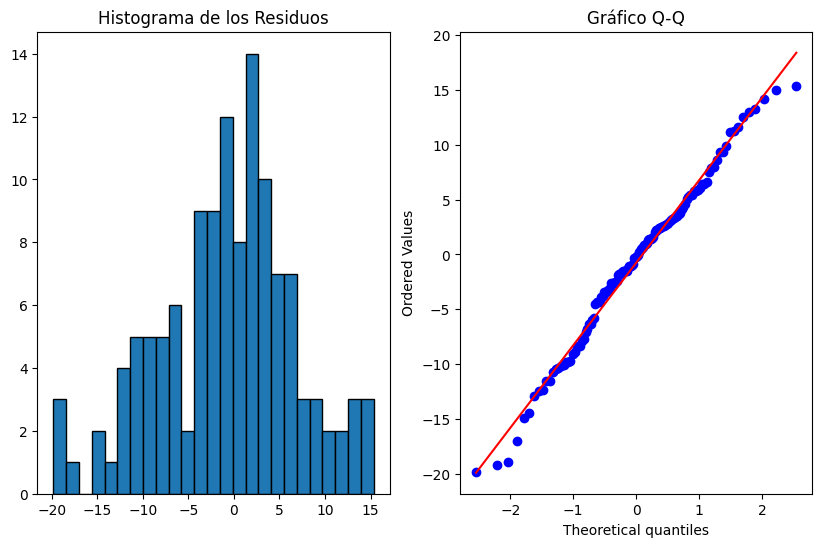

In [110]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.hist(residuals, bins=25, edgecolor='k')
plt.title("Histograma de los Residuos")

# Gráfico Q-Q
plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gráfico Q-Q")
plt.show()

In [111]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f'Statistic: {stat}, p-value: {p}')

if p > 0.05:
    print("No se rechaza la hipótesis nula: los residuos son normales")
else:
    print("Se rechaza la hipótesis nula: los residuos no son normales")

Statistic: 0.9873887896537781, p-value: 0.2989124059677124
No se rechaza la hipótesis nula: los residuos son normales


### Autocorrelación

In [112]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  10.095673    0.43214


#### No hay evidencia suficiente para rechazar la hipótesis nula. Por lo tanto, se concluye que no hay evidencia significativa de autocorrelación en los residuos hasta el lag 10.

### Homoscedasticidad

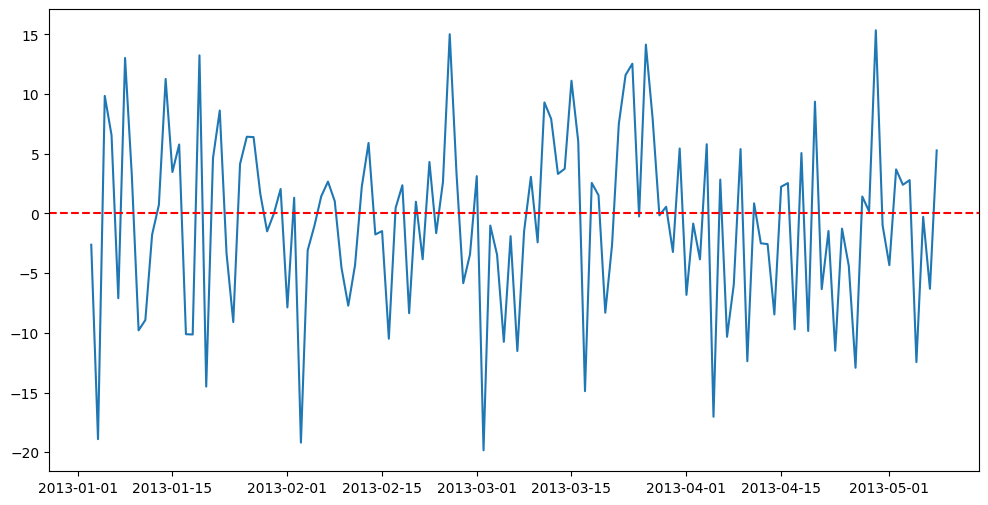

In [113]:
fig = plt.figure(figsize=(12, 6))
plt.plot(residuals,label="Residuales")
plt.axhline(y=0, color='r', linestyle='--')

In [114]:
from statsmodels.stats.diagnostic import het_arch

# Prueba de ARCH para heterocedasticidad
arch_test = het_arch(residuals)
print(f'ARCH Test Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')

ARCH Test Statistic: 14.367996843971179
p-value: 0.15685808720446096


##### El p value > 0.05  indica que no hay suficiente evidencia para rechazar la hipótesis nula de homocedasticidad. Por lo tanto, se concluye que no hay evidencia significativa de heterocedasticidad condicional en los residuos.

# **REPETIR EL PROCESOS PARA EL OTRO DATASET**

## **PROMEDIO MÓVIL**

In [149]:
predicciones = []
namecolumn = 'producto2'
df = data_producto2
test_data = df[len(df)-10:len(df)]
estimaciones_mean, promedio_mean = protocolo(data_producto2, 10, fore_ma, None, None, 3)
rmse_general = np.sqrt(mean_squared_error(test_data,predicciones ))
print(f"promedio rmse: {promedio_mean}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 34.89321713446225, rmse calculado con el total del test: 40.85271826648446


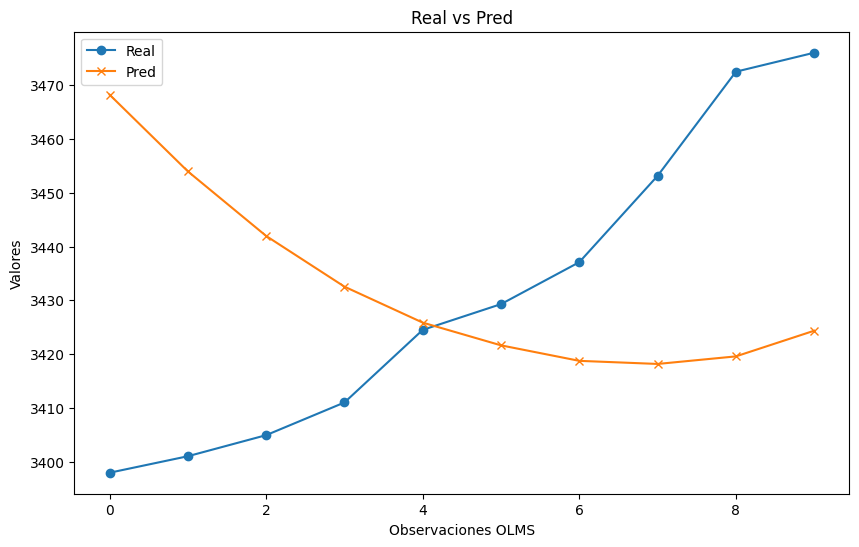

In [146]:
graficar_predicciones(estimaciones_mean)

## **Holt Winters**

In [137]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [138]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
 target es: 7.205239778379427,Eror test: add,Trend test: add,Seasonal test: add,Alpha model: 0.42,Beta model: 0.72, Gamma model: 0.31
| 1         | -7.205    | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
 target es: 22.80839302719669,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.19,Beta model: 0.35, Gamma model: 0.54
| 2         | -22.81    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
 target es: 122012.45488569842,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.21,Beta model: 0.87, Gamma model: 0.67
| 3         | -1.22e+05 | 0.2104    | 0.8706    | 0.02739   | 0.6671    | 0.8346    | 1.117     |
 target es: 9.393600432237736,Eror test: add,Trend test: add,Seasonal test: None,Alpha model: 0.94,Beta mod

In [139]:
optimizer.max

{'target': -5.803881126981333,
 'params': {'alpha': 0.9772773842666972,
  'beta': 0.99,
  'error': 0.29537996866866456,
  'gamma': 0.24392306037145534,
  'seasonal': 0.9052396791416852,
  'trend': 0.3647289382086059}}

In [143]:
params = transformar_params(optimizer.max['params'])
predicciones = []
estimaciones_hot, promedio_hot = protocolo(data_producto2, 10, train_and_evaluate_RMSE,None,params,2)
rmse_general = np.sqrt(mean_squared_error(test_data,predicciones ))
print(f"promedio rmse: {promedio_hot}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 9.275379695668017, rmse calculado con el total del test: 10.375816317207226


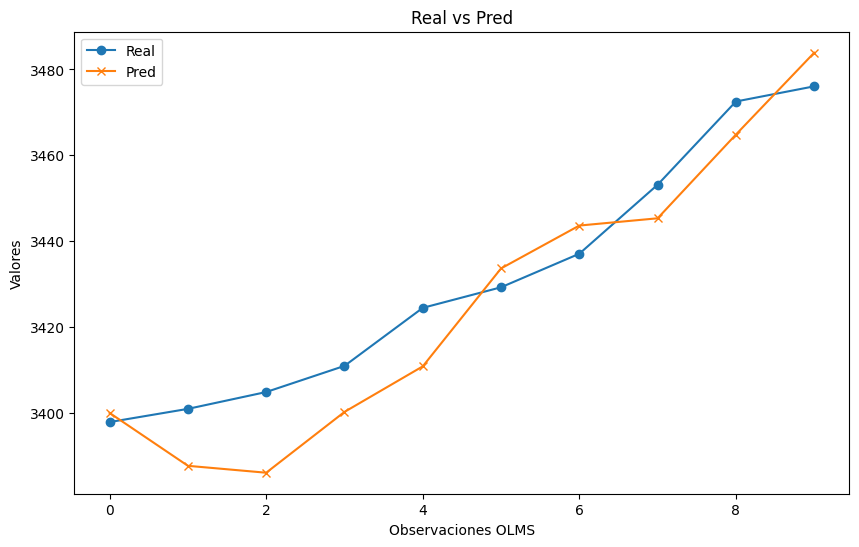

In [144]:
graficar_predicciones(estimaciones_hot)

## ESTACIONALIDAD

In [147]:
predicciones = []
estimaciones_ols, promedio_ols = protocolo(data_producto2, 10, modelo_ols_estacionalidad,1,1)
test_data = data_producto2[len(data_producto2)-10:len(data_producto2)]
predicciones_array = np.array([item[0, 0] for item in predicciones])
test_data_array = np.array(test_data)
rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))

print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 82.41530921356839, rmse calculado con el total del test: 95.29182790863052


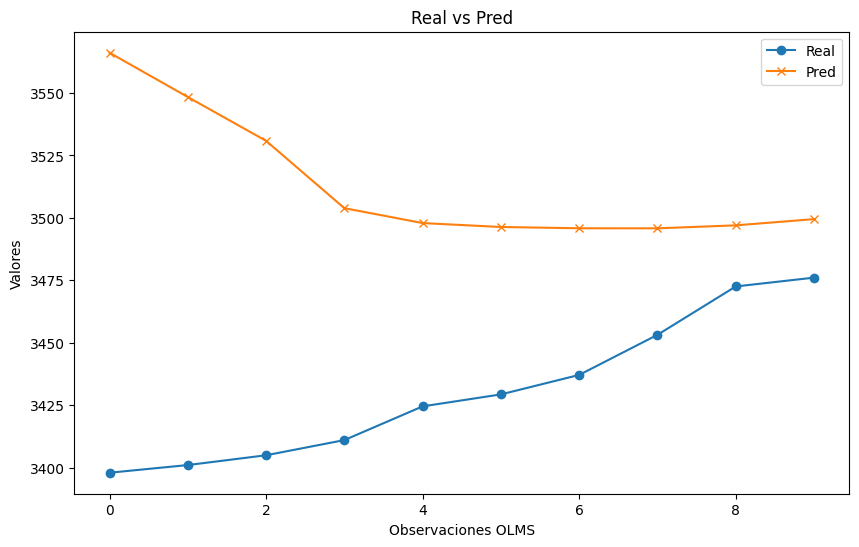

In [148]:
graficar_predicciones(estimaciones_ols)

In [150]:
predicciones = []
estimaciones_ols, promedio_ols = protocolo(data_producto2, 10, modelo_ols_estacionalidad,2,1)
predicciones_array = np.array([item[0, 0] for item in predicciones])
rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))

print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 63.971803850800555, rmse calculado con el total del test: 74.36268057801966


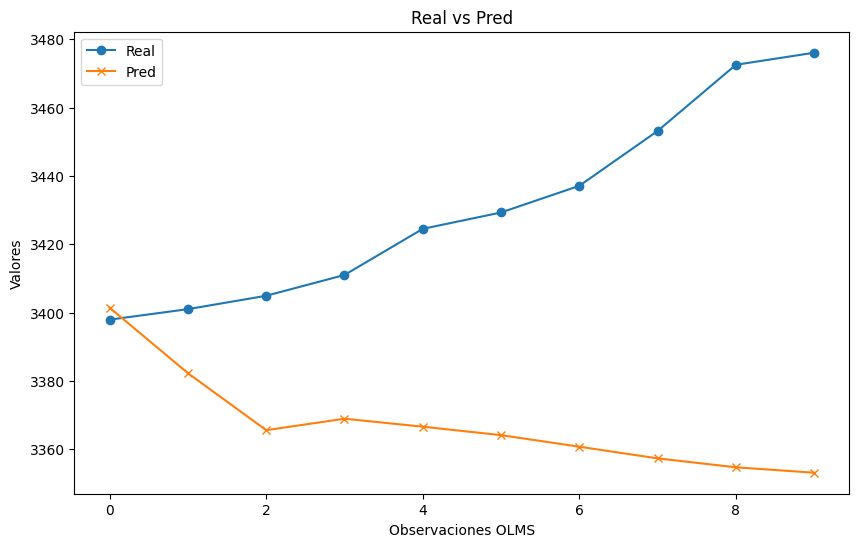

In [151]:
graficar_predicciones(estimaciones_ols)

In [152]:
predicciones = []
estimaciones_ols, promedio_ols = protocolo(data_producto2, 10, modelo_ols_estacionalidad,3,1)
predicciones_array = np.array([item[0, 0] for item in predicciones])
rmse_general = np.sqrt(mean_squared_error(test_data_array, predicciones_array))

print(f"promedio rmse: {promedio_ols}, rmse calculado con el total del test: {rmse_general}")

promedio rmse: 93.43710199178062, rmse calculado con el total del test: 103.46084782705113


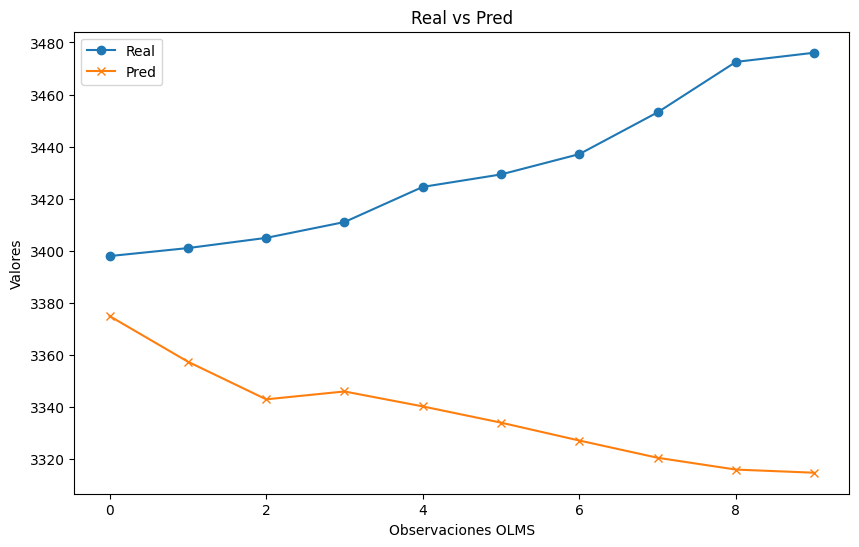

In [153]:
graficar_predicciones(estimaciones_ols)

## ARIMA

In [154]:
# Ejecutar la comparación de modelos
resultados = comparar_modelos_arima(data_producto2, horizonte=10, lista_ordenes=lista_ordenes)

# Encontrar el mejor modelo (con el menor promedio de RMSE)
mejor_modelo = min(resultados, key=lambda k: resultados[k]['average_rmse'])
print(f"\nEl mejor modelo ARIMA es el con orden {mejor_modelo} con un promedio de RMSE de {resultados[mejor_modelo]['average_rmse']}")

# Mostrar resultados promedio de RMSE por modelo
print("\nPromedio de RMSE por modelo:")
for order, result in resultados.items():
    print(f"Modelo ARIMA {order}: Promedio de RMSE = {result['average_rmse']}")

Evaluando modelo ARIMA con orden: (1, 1, 1)
Evaluando modelo ARIMA con orden: (2, 1, 1)
Evaluando modelo ARIMA con orden: (1, 2, 1)
Evaluando modelo ARIMA con orden: (1, 1, 2)
Evaluando modelo ARIMA con orden: (2, 2, 2)
Evaluando modelo ARIMA con orden: (2, 1, 2)
Evaluando modelo ARIMA con orden: (3, 1, 1)
Evaluando modelo ARIMA con orden: (1, 1, 3)

El mejor modelo ARIMA es el con orden (1, 1, 2) con un promedio de RMSE de 7.921655657945621

Promedio de RMSE por modelo:
Modelo ARIMA (1, 1, 1): Promedio de RMSE = 10.064377301368177
Modelo ARIMA (2, 1, 1): Promedio de RMSE = 8.419691675977173
Modelo ARIMA (1, 2, 1): Promedio de RMSE = 8.92402572297442
Modelo ARIMA (1, 1, 2): Promedio de RMSE = 7.921655657945621
Modelo ARIMA (2, 2, 2): Promedio de RMSE = 8.814222966637862
Modelo ARIMA (2, 1, 2): Promedio de RMSE = 8.484663214671764
Modelo ARIMA (3, 1, 1): Promedio de RMSE = 8.354343345469351
Modelo ARIMA (1, 1, 3): Promedio de RMSE = 8.47975811485917


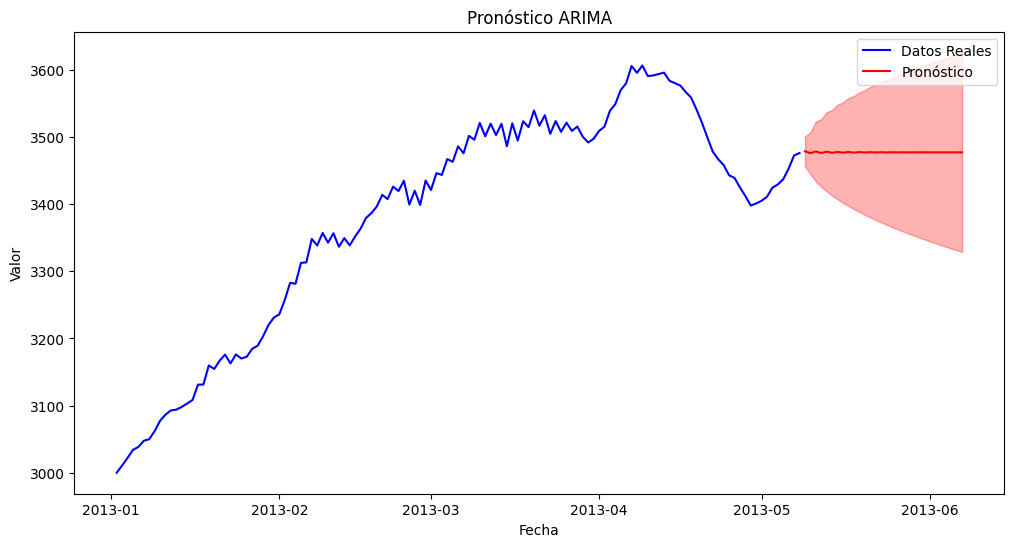

In [155]:
# Definir el horizonte de pronóstico (1 mes, ajustar según frecuencia de datos)
horizonte = 30  # Asumiendo datos diarios, ajusta si es necesario

# Pronosticar con el mejor modelo
predicciones_mean, predicciones_conf_int = pronosticar_con_mejor_modelo(data_producto2, mejor_modelo, horizonte)

# Crear un índice de fechas para las predicciones
fechas_futuras = pd.date_range(start=data_producto2.index[-1] + pd.Timedelta(days=1), periods=horizonte, freq='D')
predicciones_df = pd.DataFrame({
    'Predicción': predicciones_mean,
    'Inferior': predicciones_conf_int.iloc[:, 0],
    'Superior': predicciones_conf_int.iloc[:, 1]
}, index=fechas_futuras)

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(data_producto2, label='Datos Reales', color='blue')
plt.plot(predicciones_df.index, predicciones_df['Predicción'], label='Pronóstico', color='red')
plt.fill_between(predicciones_df.index, predicciones_df['Inferior'], predicciones_df['Superior'], color='red', alpha=0.3)
plt.title('Pronóstico ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

## PRUEBA DE SUPUESTOS

In [156]:
modelo_final = ARIMA(data_producto2, order=mejor_modelo)
modelo_ajustado = modelo_final.fit()
residuals = modelo_ajustado.resid.iloc[1:]

In [157]:
residuals

Fecha
2013-01-03    10.953620
2013-01-04    15.199638
2013-01-05     8.816127
2013-01-06     3.092277
2013-01-07     7.062866
                ...    
2013-05-04     3.530714
2013-05-05     2.844073
2013-05-06    18.826920
2013-05-07    16.049232
2013-05-08    -1.576240
Length: 126, dtype: float64

### Normalidad

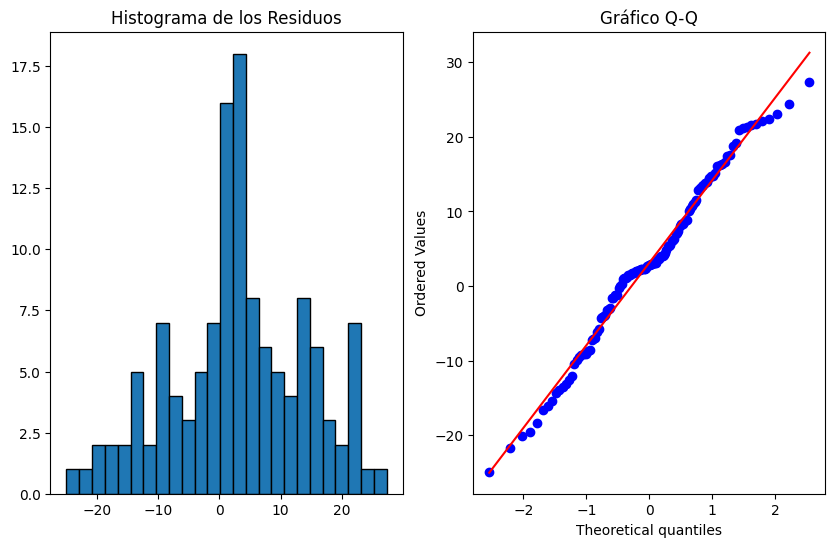

In [158]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.hist(residuals, bins=25, edgecolor='k')
plt.title("Histograma de los Residuos")

# Gráfico Q-Q
plt.subplot(122)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Gráfico Q-Q")
plt.show()

In [159]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f'Statistic: {stat}, p-value: {p}')

if p > 0.05:
    print("No se rechaza la hipótesis nula: los residuos son normales")
else:
    print("Se rechaza la hipótesis nula: los residuos no son normales")

Statistic: 0.9851953387260437, p-value: 0.1873420923948288
No se rechaza la hipótesis nula: los residuos son normales


### Autocorrelación

In [160]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10  37.643512   0.000044


#### Se rechaza la hipótesis nula por tanto se puede concluir que hay evidencia significativa de autocorrelación en los residuos hasta el lag 10.

### Homoscedasticidad

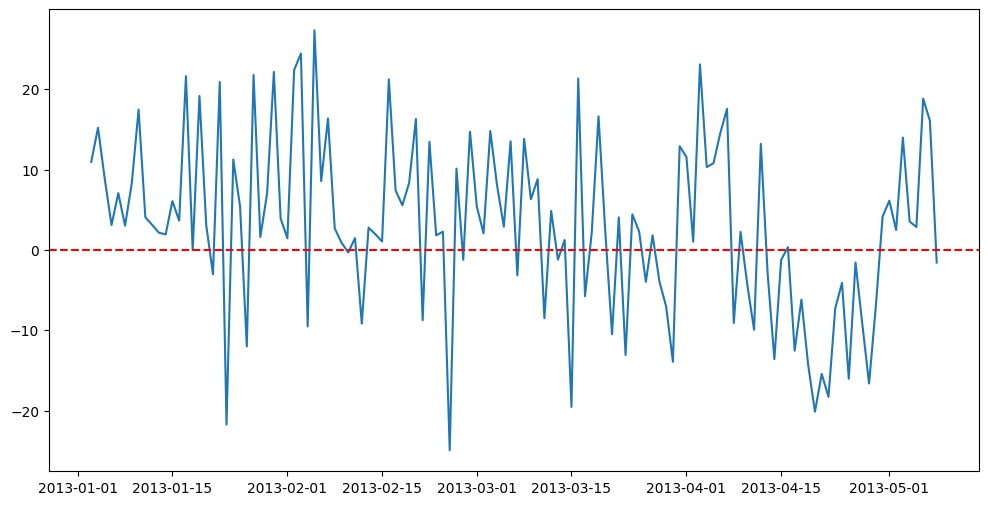

In [161]:
fig = plt.figure(figsize=(12, 6))
plt.plot(residuals,label="Residuales")
plt.axhline(y=0, color='r', linestyle='--')

In [162]:
from statsmodels.stats.diagnostic import het_arch

# Prueba de ARCH para heterocedasticidad
arch_test = het_arch(residuals)
print(f'ARCH Test Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')

ARCH Test Statistic: 8.836965008444233
p-value: 0.5476430634965188


##### El p value > 0.05  indica que no hay suficiente evidencia para rechazar la hipótesis nula de homocedasticidad. Por lo tanto, se concluye que no hay evidencia significativa de heterocedasticidad condicional en los residuos.